Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [81]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import seaborn as sns
from glob import glob

In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [14]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("C:\\melanoma\\Train")
data_dir_test = pathlib.Path('C:\\melanoma\\Test')

In [15]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [16]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [24]:
## training data set
## seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing image to 180,180
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [25]:
## validation data set
## seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing image to 180,180
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [26]:
# List of skin cancers 

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [30]:
len(class_names)

9

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

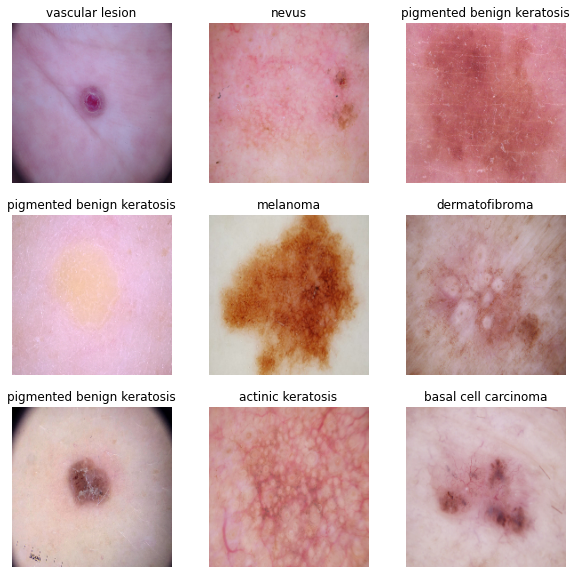

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [35]:
## Another way to print the batch shape and labels shape

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [36]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [44]:

## Building a Basic model with 2 layers and MaxPolling layer to start with 
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [45]:
### using adam optimizer 
### Using crossentropy loss function 

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [46]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64800)            

### Train the model

In [47]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 31s 553ms/step - loss: 3.1402 - accuracy: 0.2015 - val_loss: 1.9314 - val_accuracy: 0.2640
Epoch 2/20
56/56 [==============================] - 31s 563ms/step - loss: 1.9009 - accuracy: 0.2924 - val_loss: 1.7653 - val_accuracy: 0.3826
Epoch 3/20
56/56 [==============================] - 33s 583ms/step - loss: 1.7019 - accuracy: 0.4079 - val_loss: 1.5402 - val_accuracy: 0.4832
Epoch 4/20
56/56 [==============================] - 31s 551ms/step - loss: 1.4417 - accuracy: 0.5257 - val_loss: 1.5287 - val_accuracy: 0.4430
Epoch 5/20
56/56 [==============================] - 30s 535ms/step - loss: 1.3822 - accuracy: 0.5251 - val_loss: 1.4550 - val_accuracy: 0.4855
Epoch 6/20
56/56 [==============================] - 31s 560ms/step - loss: 1.2686 - accuracy: 0.5474 - val_loss: 1.5256 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 30s 531ms/step - loss: 1.1521 - accuracy: 0.5921 - val_loss: 1.4463 - val_accuracy: 0.5369

### Visualizing training results

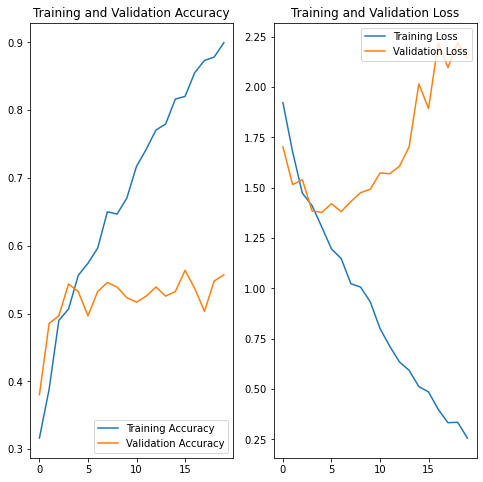

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

1. Training and validation accuracy vary a lot and there is huge gap.
2. Overall the validation accuracy is too low and not even corssed the 60% mark.
3. As the training accuracy is increasing linearly but the validation accuracy is not, hence it is a Overfit model.
3. We can try data augementation and drop outs to improve model accuracy.


In [50]:
# Choosing a horizontal augumentation strategy
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)


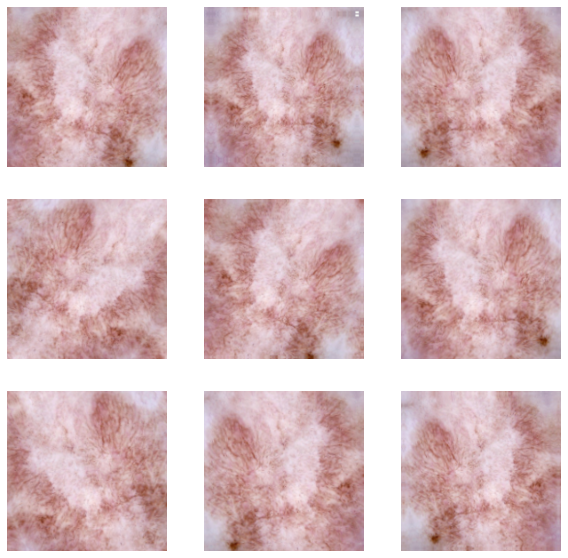

In [51]:
# Augmentation strategy for an image.
 
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
    

### Todo:
### Create the model, compile and train the model


In [53]:
## Using a Dropout layer as we observed overfitting.

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [54]:
## Compiling model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [55]:
## Viewing model summary 
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [56]:
## Training model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 45s 785ms/step - loss: 2.0753 - accuracy: 0.2003 - val_loss: 1.9707 - val_accuracy: 0.2752
Epoch 2/20
56/56 [==============================] - 43s 763ms/step - loss: 1.9345 - accuracy: 0.2840 - val_loss: 1.8529 - val_accuracy: 0.3132
Epoch 3/20
56/56 [==============================] - 43s 767ms/step - loss: 1.7497 - accuracy: 0.3605 - val_loss: 1.9819 - val_accuracy: 0.3177
Epoch 4/20
56/56 [==============================] - 44s 778ms/step - loss: 1.5727 - accuracy: 0.4448 - val_loss: 1.5289 - val_accuracy: 0.4720
Epoch 5/20
56/56 [==============================] - 43s 768ms/step - loss: 1.4668 - accuracy: 0.4866 - val_loss: 1.4627 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 44s 777ms/step - loss: 1.4172 - accuracy: 0.5056 - val_loss: 1.3660 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 44s 789ms/step - loss: 1.3606 - accuracy: 0.5028 - val_loss: 1.5811 - val_accuracy: 0.4541

### Visualizing the results

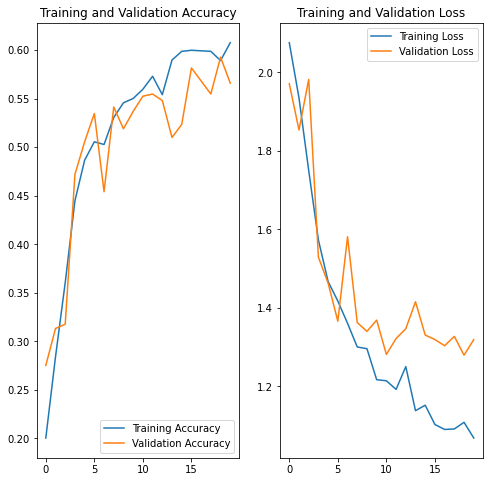

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

1. Model performance improved compared to previous model 
2. Training and validation accuracy are close 
3. But overall the accuracy is under 60%. 


#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [78]:
## Your code goes here.



#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [58]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [77]:
path_to_training_dataset="C:\\melanoma\\Train\\"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to C:\melanoma\Train\actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x24145FCA4F0>: 100%|█| 500/500 [00:16<00:
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to C:\melanoma\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x24140A05460>: 100%|█| 500/500 [00:16<00:00, 30.03 Samples/
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to C:\melanoma\Train\dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x24143A27C70>: 100%|█| 500/500 [00:17<00:
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to C:\melanoma\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x24143A3CD90>: 100%|█| 500/500 [01:19<00:00,  6.30 Samples/
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to C:\melanoma\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x24145FDA5E0>: 100%|█| 500/500 [01:19<00:00,  6.25 Samples/
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to C:\melanoma\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x24140A2D280>: 100%|█| 500/500 [00:16<00:00, 30.26 Samples/
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to C:\melanoma\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x24143A3CB80>: 100%|█| 500/500 [00:41<00:00, 12.19 Samples
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to C:\melanoma\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x24145FDA790>: 100%|█| 500/500 [00:16<00:00, 29.44 Samples/
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to C:\melanoma\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x24140A11F70>: 100%|█| 500/500 [00:17<00:00, 29.03 Samples/


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [79]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [82]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['C:\\melanoma\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_1c0cc87b-72b3-4a4e-854e-9676d9a0d967.jpg',
 'C:\\melanoma\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_631ab8a1-da77-4e63-bf43-ced8d0e222c1.jpg',
 'C:\\melanoma\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_639f9563-1e0d-4c68-8cab-b6bb5ce1b73a.jpg',
 'C:\\melanoma\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7973580c-d045-4007-a904-75bce40d63fc.jpg',
 'C:\\melanoma\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_79d04bd9-999e-496c-90b0-371cfde5f298.jpg',
 'C:\\melanoma\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_1d45a6fb-627e-46f1-8b8e-60112cc7bd8e.jpg',
 'C:\\melanoma\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_1e2d068a-59a2-4583-8d1d-3666c95b1e21.jpg',
 'C:\\melanoma\\Train\\actinic keratosis\

In [83]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [84]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

NameError: name 'path_list_new' is not defined

In [85]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

NameError: name 'dataframe_dict_new' is not defined

In [ ]:
new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history = # your model fit code

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

